In [89]:
from SpecReduction import SpecFunctions as sf
import numpy as np
import pandas as pd
import scipy
import scipy.optimize as opt
from scipy.optimize import curve_fit
import specreduce
from specreduce import WavelengthCalibration1D as wav_cal
from astropy.io import fits
import matplotlib as mpl
import matplotlib.pyplot as plt
from aquarel import load_theme

In [2]:
theme = load_theme('arctic_dark')
theme.apply()

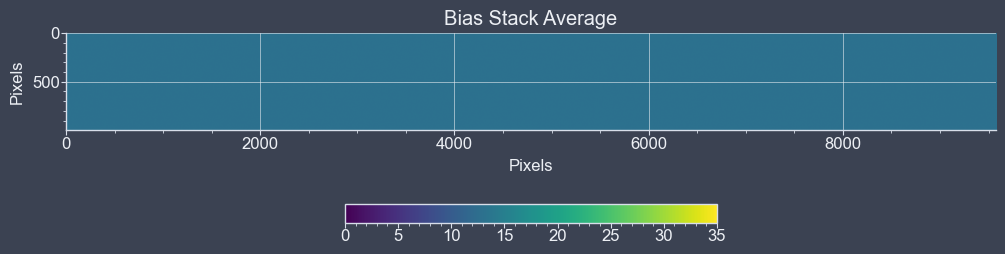

In [3]:
#median of full bias frames stack
bias_path = f'Lab Day 20250729/Bias_729/2025-07-29_22_38_47Z/2025-07-29-2238_7-CapObj_'
bias_shape = fits.open(f'Lab Day 20250729/Bias_729/2025-07-29_22_38_47Z/2025-07-29-2238_7-CapObj_0008.FIT')[0].data.shape
bias_avg = sf.median_img(100, bias_path, bias_shape[0], bias_shape[1])

plt.figure(figsize = (12,12))
plt.imshow(bias_avg)
plt.title('Bias Stack Average')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.colorbar(shrink = 0.4, location = 'bottom', pad = 0.08)
plt.show()


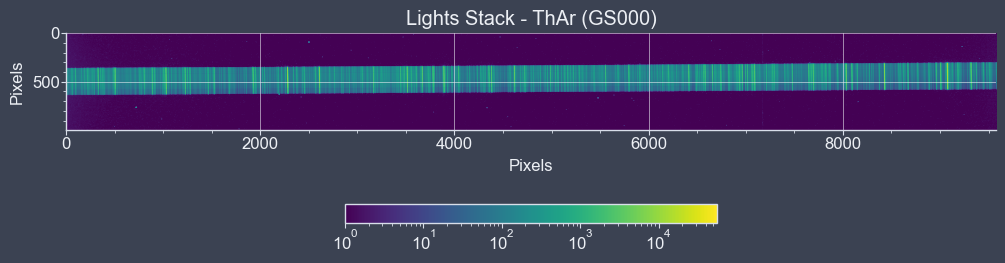

In [4]:
#median of full lights stack 
lights_path = f'Lab Day 20250729/ThAr_2s_lights/2025-07-29-2227_6-CapObj_'
lights_shape = fits.open(f'Lab Day 20250729/ThAr_2s_lights/2025-07-29-2227_6-CapObj_0009.FIT')[0].data.shape
lights_avg = sf.median_img(100,lights_path, lights_shape[0], lights_shape[1])

#subtract bias from lights
lights_avg = lights_avg - bias_avg

plt.figure(figsize = (12,12))
plt.imshow(lights_avg, norm = 'log')
plt.title('Lights Stack - ThAr (GS000)')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.colorbar(shrink = 0.4, location = 'bottom', pad = 0.08)
plt.show()

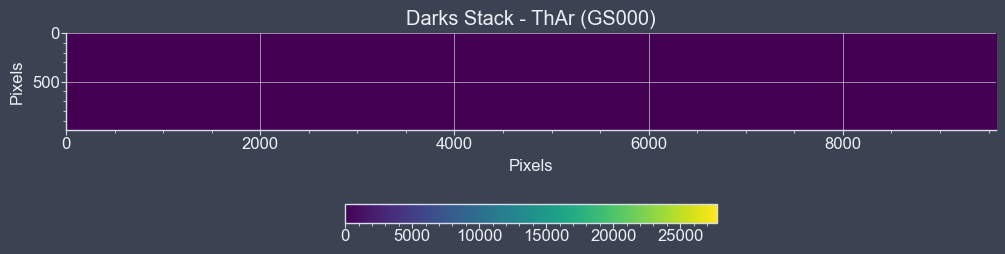

In [5]:
#median of darks stack (10 images)
darks_path = f'Lab Day 20250729/ThAr_2s_darks/2025-07-29-2233_2-CapObj_'
darks_shape = fits.open(f'Lab Day 20250729/ThAr_2s_darks/2025-07-29-2233_2-CapObj_0009.FIT')[0].data.shape
darks_avg = sf.median_img(100,darks_path, darks_shape[0], darks_shape[1])

#subtract bias from darks
darks_avg = darks_avg - bias_avg

plt.figure(figsize = (12,12))
plt.imshow(darks_avg)
plt.title('Darks Stack - ThAr (GS000)')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.colorbar(shrink = 0.4, location = 'bottom', pad = 0.08)
plt.show()


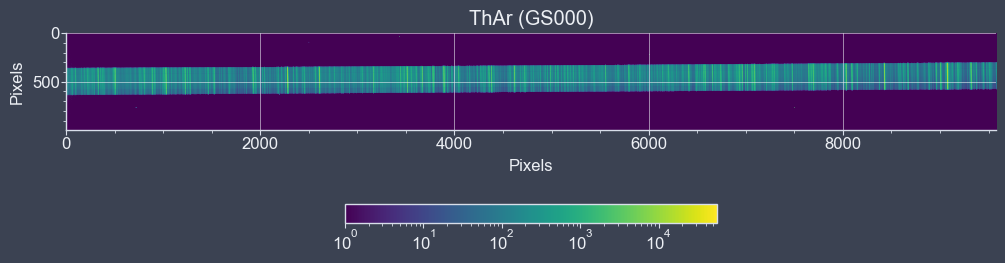

In [6]:
ThAr_subtracted = lights_avg - darks_avg

plt.figure(figsize = (12,12))
plt.imshow(ThAr_subtracted, norm = 'log')
plt.title('ThAr (GS000)')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.grid(True)
plt.colorbar(shrink = 0.4, location = 'bottom', pad = 0.08)
plt.savefig('ThAr_GS000_full_stack_spectrum')
plt.show()

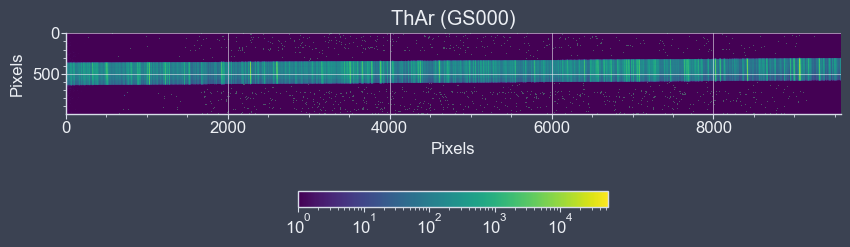

In [7]:
#Replot previous image using saved fits file - saves time/power
ThAr_download_sub = fits.open(f'subtracted_ThArGS000_short_stack.FIT')[0].data
plt.figure(figsize = (10,10))
plt.imshow(ThAr_download_sub, norm = 'log')
plt.title('ThAr (GS000)')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.grid(True)
plt.colorbar(shrink = 0.4, location = 'bottom', pad = 0.1)
plt.show()

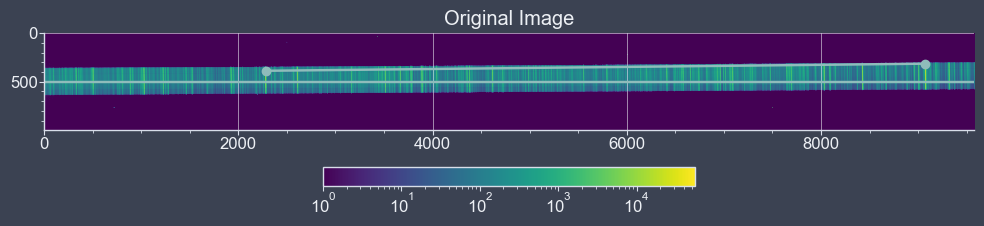

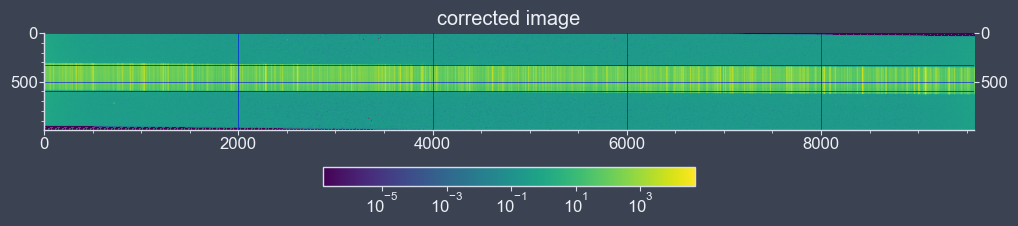

In [8]:
corrected_ThAr = sf.straight_spec(ThAr_subtracted)

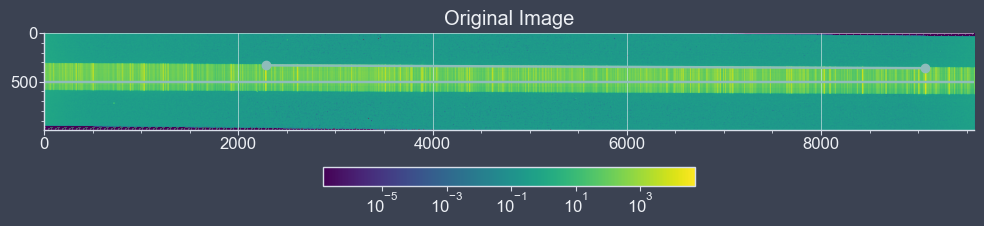

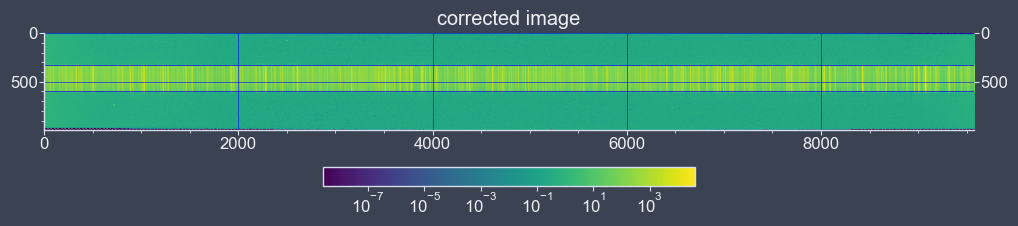

In [9]:
final_corrected_ThAr = sf.straight_spec(corrected_ThAr)

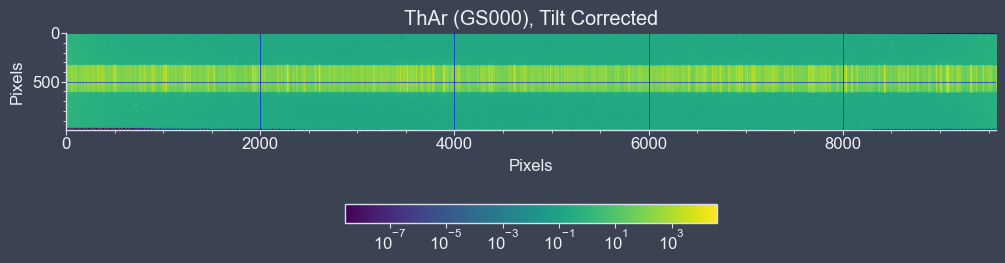

In [10]:
plt.figure(figsize = (12,12))
plt.imshow(final_corrected_ThAr, norm = 'log')
plt.title('ThAr (GS000), Tilt Corrected')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.grid(True, color = 'b')
plt.colorbar(shrink = 0.4, location = 'bottom', pad = 0.08)
plt.savefig('ThAr_GS000_full_stack_untilt')
plt.show()

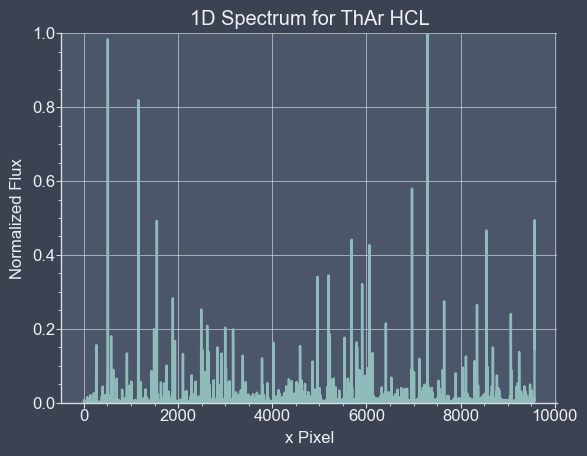

In [11]:
ThAr_spec = sf.make1D(final_corrected_ThAr)
ThAr_spec = np.flipud(ThAr_spec)

plt.plot(ThAr_spec)
plt.xlabel('x Pixel')
plt.ylabel('Normalized Flux')
plt.title('1D Spectrum for ThAr HCL')
plt.ylim(0, 1)
# plt.gca().invert_xaxis()
# plt.savefig('1D_ThArGS000_spec')
plt.show()

Text(0, 0.5, 'Normalized Flux')

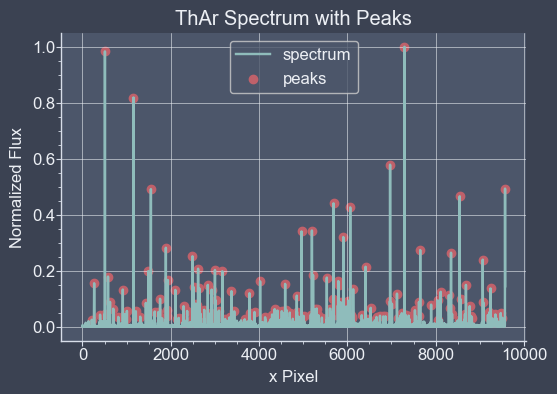

In [43]:
#locate peaks
peak_locs, peak_props = scipy.signal.find_peaks(ThAr_spec, height = 0.025)
peak_vals = peak_props['peak_heights']
fwhm = scipy.signal.peak_widths(ThAr_spec, peak_locs, rel_height = 0.5)[0]
fw = scipy.signal.peak_widths(ThAr_spec, peak_locs, rel_height = 0.95)[0]


plt.figure(figsize = (6,4))
plt.plot(ThAr_spec, label = 'spectrum')
plt.scatter(peak_locs, peak_vals, color = '#bf616a', label = 'peaks')
plt.legend()
plt.title('ThAr Spectrum with Peaks')
plt.xlabel('x Pixel')
# plt.xlim()
plt.ylabel('Normalized Flux')

Text(0, 0.5, 'Normalized Flux')

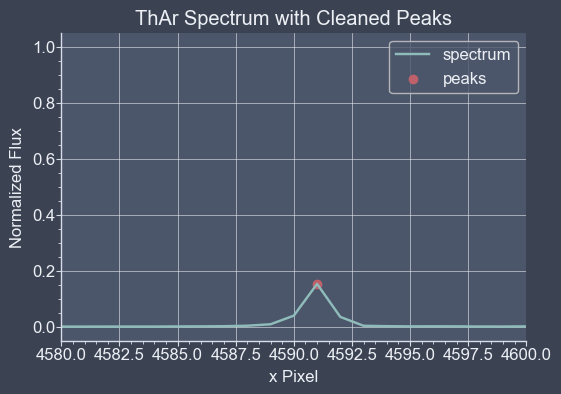

In [81]:
pixels = np.linspace(0, ThAr_spec.size, ThAr_spec.size + 1)
peak_locs_clean = np.array([])
peak_vals_clean = np.array([])
fwhm_clean = np.array([])
fw_clean = np.array([])
for x in range(peak_locs.size - 1):
    min_loc = np.floor(peak_locs[x] - fw[x])
    next_min_loc = np.floor(peak_locs[x + 1] - fw[x + 1])
    max_loc = np.ceil(peak_locs[x] + fw[x])
    prev_max_loc = np.ceil(peak_locs[x - 1] + fw[x - 1])
    if x == 0 and next_min_loc > max_loc:
        peak_locs_clean = np.append(peak_locs_clean, peak_locs[x])
        peak_vals_clean = np.append(peak_vals_clean, peak_vals[x])
        fwhm_clean = np.append(fwhm_clean, fwhm[x])
        fw_clean = np.append(fw_clean, fw[x])
        continue
    if next_min_loc > max_loc and prev_max_loc < min_loc:
        peak_locs_clean = np.append(peak_locs_clean, peak_locs[x])
        peak_vals_clean = np.append(peak_vals_clean, peak_vals[x])
        fwhm_clean = np.append(fwhm_clean, fwhm[x])
        fw_clean = np.append(fw_clean, fw[x])

plt.figure(figsize = (6,4))
plt.plot(ThAr_spec, label = 'spectrum')
plt.scatter(peak_locs_clean, peak_vals_clean, color = '#bf616a', label = 'peaks')
plt.legend()
plt.title('ThAr Spectrum with Cleaned Peaks')
plt.xlabel('x Pixel')
plt.xlim(4580,4600)
plt.ylabel('Normalized Flux')

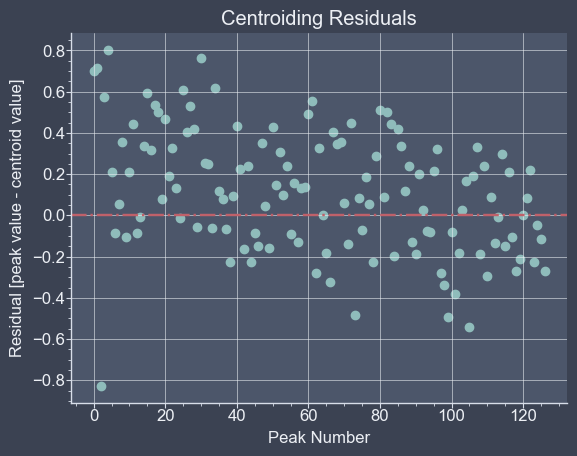

In [83]:
#centroid residuals
residuals = np.array([])
for p in range(peak_locs_clean.size):
    residual = peak_locs_clean[p] - x_center[p]
    residuals = np.append(residuals, residual)

plt.scatter(np.arange(len(residuals)),residuals)
plt.title('Centroiding Residuals')
plt.xlabel('Peak Number')
plt.ylabel('Residual [peak value - centroid value]')
plt.axhline(0,ls='-.', c = '#bf616a')
plt.show()

In [92]:
#specreduce wavelength calibration
line_list_Ne = np.genfromtxt('Ne_lines.csv', delimiter = ',')
test_cal = wav_cal(ThAr_spec, line_pixels=x_center, line_wavelengths=line_list_Ne[0])
calibrated_spectrum = test_cal.apply_to_spectrum(ThAr_spec)


ValueError: Input spectrum must be Spectrum.

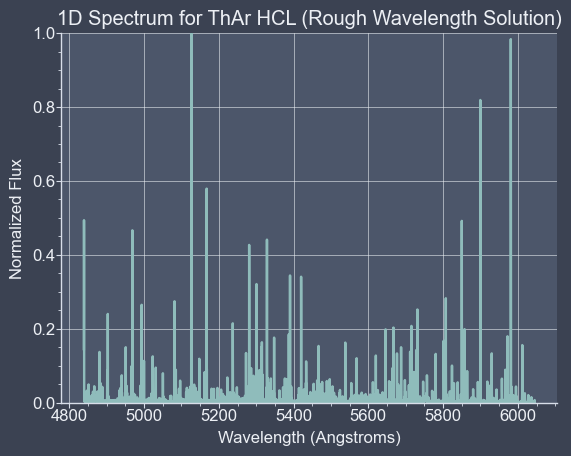

In [57]:
speed_solution = np.genfromtxt('speedy_wav.csv', delimiter = ',')

plt.plot(speed_solution[1], ThAr_spec)
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Normalized Flux')
plt.title('1D Spectrum for ThAr HCL (Rough Wavelength Solution)')
plt.ylim(0,1)
# plt.gca().invert_xaxis()
# plt.savefig('1D_ThArGS000_spec_rough_sol')
plt.show()

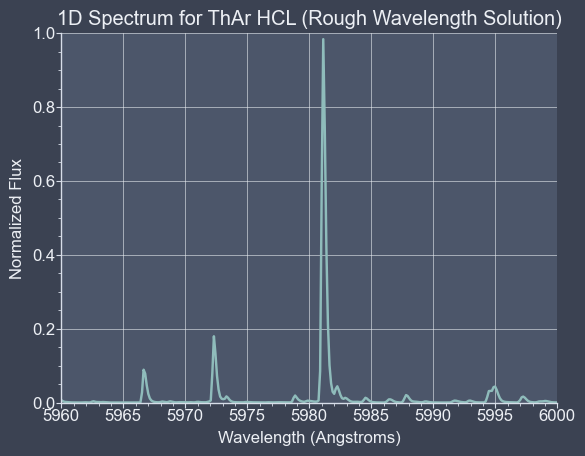

In [58]:
plt.plot(speed_solution[1], ThAr_spec)
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Normalized Flux')
plt.title('1D Spectrum for ThAr HCL (Rough Wavelength Solution)')
plt.ylim(0,1)
plt.xlim(5960,6000)
# plt.savefig('1D_ThArGS000_spec_rough_sol')
plt.show()